#### PSM FDR 0.01 and Prot FDR 0.01   Fasta: human reviewed 

#### phos dataset is not compared because no proteins passed protein filter or few proteins passed protein filter

## MSstatsTMT Analysis：Proteomics differential expression downstream analysis

#### The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsTMT](https://github.com/bigbio/proteomicstmt): TMT pipeline based on OpenMS and nextflow.

For the data with isobaric labeling, using the [MSstatsTMT](https://www.bioconductor.org/packages/release/bioc/html/MSstatsTMT.html) to perform the downstream data analysis. Major steps in the data processing are the following:

- Importing data from the pipeline. The major source of data are:
  - out.mzTab
  - metadata.sdrf.tsv or experimental_design.tsv 

In [2]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [65]:
import pandas as pd
import gzip
import numpy as np
from matplotlib import pyplot as plt
from pyteomics import mztab
from pyvenn import venn 

def remove_decoy(Pro):
    if "CONTAMINANT" in Pro or "DECOY_" in Pro or "Reverse" in Pro or "contaminant" in Pro:
        return None
    else:
        return Pro

In [3]:
# preprocess out_msstats.csv

path = "../datasets/PXD017721/out_msstats.csv.gz"
f_name = path.replace(".gz", "")
g_file = gzip.GzipFile(path)
with open(f_name, "wb+") as f:
    f.write(g_file.read())

path = "../datasets/PXD017721/out.mzTab.gz"
f_name = path.replace(".gz", "")
g_file = gzip.GzipFile(path)
with open(f_name, "wb+") as f:
    f.write(g_file.read())
    
data = pd.read_csv("../datasets/PXD017721/out_msstats.csv", sep=",")
data['ProteinName'] = data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)
data.dropna(axis=0, how='any', inplace=True, subset=['ProteinName'])
data.to_csv("../datasets/PXD017721/out_msstats_pre.csv", index=False, sep=",")

### Comparing the number of quantified proteins and identified proteins

#### proteomicstmt identified and quantified more proteins. And most of the proteins given in the article is in proteomicstmt result

7042
6140
5896
5412
5070


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21c80fb2388>)

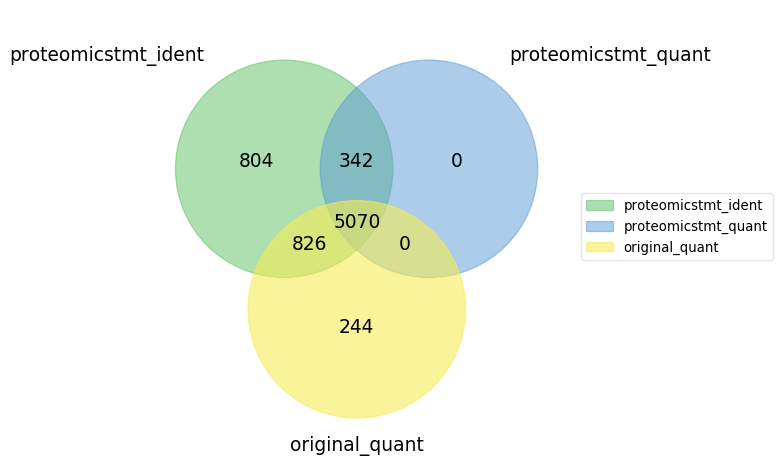

In [4]:
%matplotlib inline



def compare_preprocess(proteins):
    if "," in proteins:
        s_protein = ','.join(sorted(proteins.replace(" ", "").split(",")))
        return s_protein
    else:
        return proteins
    
original_Neg_result = pd.read_csv("../datasets/PXD017721/All Fractions-Neg-24H.csv", sep=',', header=None)
original_Pos_result = pd.read_csv("../datasets/PXD017721/All Fractions-Pos-24H.csv", sep=',', header=None)

original_Neg_result['ProteinName'] = original_Neg_result.apply(lambda x: remove_decoy(x[0]), axis=1)
original_Neg_result.dropna(axis=0, how='any', inplace=True, subset=['ProteinName'])

original_Pos_result['ProteinName'] = original_Pos_result.apply(lambda x: remove_decoy(x[0]), axis=1)
original_Pos_result.dropna(axis=0, how='any', inplace=True, subset=['ProteinName'])

a = set(set(original_Neg_result["ProteinName"]).union(set(original_Pos_result["ProteinName"])))

data = mztab.MzTab("../datasets/PXD017721/out.mzTab")
prot_table = data.protein_table
prot_table['accession'] = prot_table.apply(lambda x: remove_decoy(x['accession']), axis=1)
prot_table.dropna(axis=0, how='any', inplace=True, subset=['accession'])
prot_table['accession'] = prot_table.apply(lambda x: x['accession'].split('|')[1], axis=1)

print(len(set(prot_table['accession'])))
print(len(a))
print(len(set(prot_table['accession']).intersection(set(a))))

msstats_data = pd.read_csv("../datasets/PXD017721/out_msstats_pre.csv", sep=",", header=0)
print(len(set(msstats_data['ProteinName'])))

msstats_data['ProteinName'] = msstats_data.apply(lambda x: x['ProteinName'].split('|')[1], axis=1)
print(len(set(msstats_data['ProteinName']).intersection(a)))

labels = venn.get_labels([set(prot_table['accession']), set(msstats_data['ProteinName']), set(a)], fill='number')
venn.venn3(labels, names=["proteomicstmt_ident", "proteomicstmt_quant", "original_quant"], figsize = (6, 6))


### Reproducibility evaluation within biological replicates

In [4]:
%%R -w 800 -h 600

library("MSstatsTMT", warn.conflicts = F, quietly = T, verbose = F)
library("psych")

data_folder = '../datasets/PXD017721'
setwd(data_folder)

In [5]:
%%R -w 800 -h 600

openms_output = './out_msstats_pre.csv'
msstats_input = './msstats_input.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)


# write.csv(input.om, file=msstats_input, row.names=FALSE)

INFO  [2021-10-27 15:02:06] ** Raw data from OpenMS imported successfully.
INFO  [2021-10-27 15:02:08] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-10-27 15:02:09] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-10-27 15:02:09] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-10-27 15:02:10] ** Shared peptides are removed.
INFO  [2021-10-27 15:02:10] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-10-27 15:03:03] ** PSMs have been aggregated to peptide ions.
INFO  [2021-10-27 15:03:08] ** For peptides overlapped between fractions of 1_1_1 use the fraction with maximal average abundance.
INFO  [2021-10-27 15:03:12] ** For peptides overl

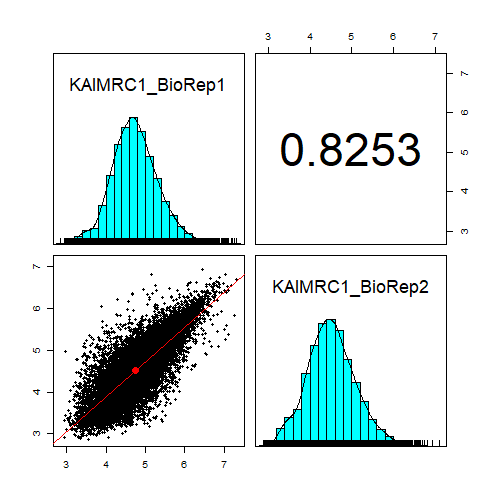

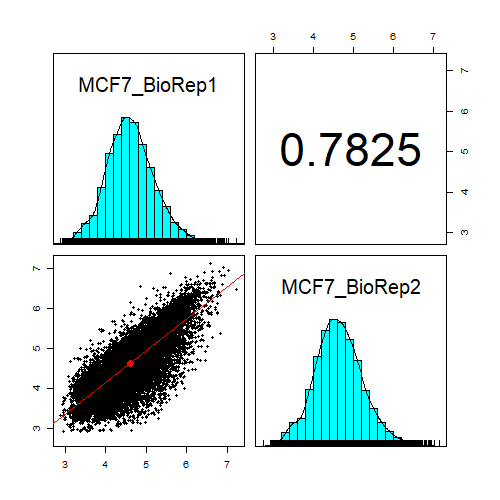

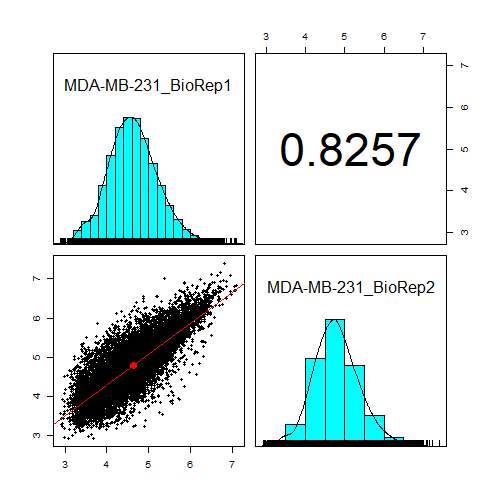

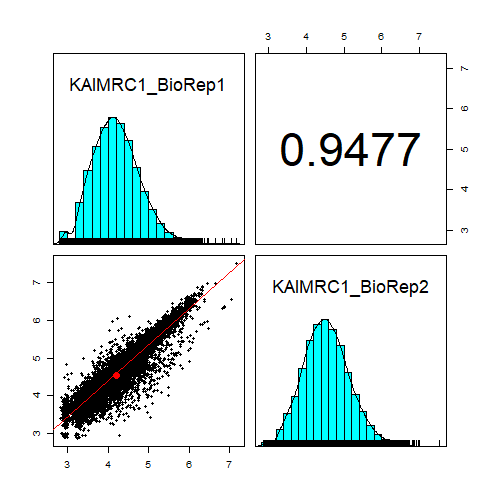

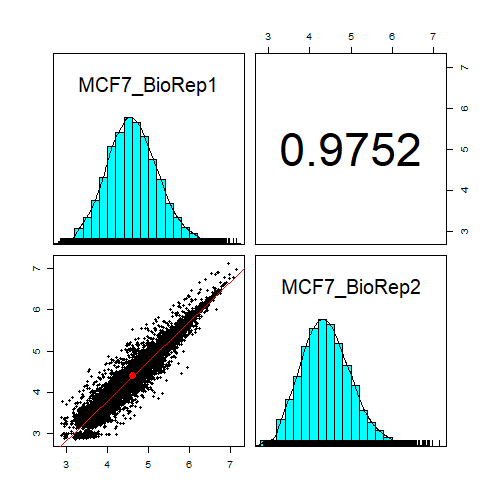

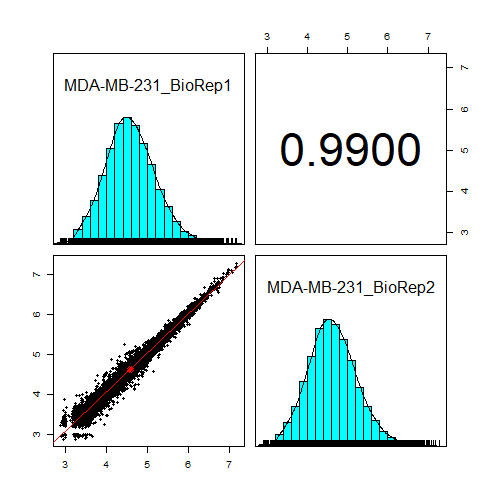

In [25]:
%%R -w 500 -h 500

# KAIMRC1|Starve (No FBS)
KAIMRC1_Starve <- subset(input.om, Condition=="KAIMRC1|Starve (No FBS)|no enrichment")
KAIMRC1_Starve_T = data.frame()
KAIMRC1_Starve_T <- subset(KAIMRC1_Starve, Channel=='1', select=c('Intensity'))
KAIMRC1_Starve_T[2] <- subset(KAIMRC1_Starve, Channel=='2', select=c('Intensity'))
colnames(KAIMRC1_Starve_T) <- c('KAIMRC1_BioRep1', 'KAIMRC1_BioRep2')
pairs.panels(log10(KAIMRC1_Starve_T), lm = TRUE, digits=4)

MCF7_Starve <- subset(input.om, Condition=="MCF7|Starve (No FBS)|no enrichment")
MCF7_Starve_T = data.frame()
MCF7_Starve_T <- subset(MCF7_Starve, Channel=='3', select=c('Intensity'))
MCF7_Starve_T[2] <- subset(MCF7_Starve, Channel=='4', select=c('Intensity'))
colnames(MCF7_Starve_T) <- c('MCF7_BioRep1', 'MCF7_BioRep2')
pairs.panels(log10(MCF7_Starve_T), lm = TRUE, digits=4)

MDMB231_Starve <- subset(input.om, Condition=="MD-MB-231|Starve (No FBS)|no enrichment")
MDMB231_Starve_T = data.frame()
MDMB231_Starve_T <- subset(MDMB231_Starve, Channel=='5', select=c('Intensity'))
MDMB231_Starve_T[2] <- subset(MDMB231_Starve, Channel=='6', select=c('Intensity'))
colnames(MDMB231_Starve_T) <- c('MDA-MB-231_BioRep1', 'MDA-MB-231_BioRep2')
pairs.panels(log10(MDMB231_Starve_T), lm = TRUE, digits=4)



# KAIMRC1|Fed (With FBS)
KAIMRC1_Fed <- subset(input.om, Condition=="KAIMRC1|Fed (With FBS)|no enrichment")
KAIMRC1_Fed_T = data.frame()
KAIMRC1_Fed_T <- subset(KAIMRC1_Fed, Channel=='1', select=c('Intensity'))
KAIMRC1_Fed_T[2] <- subset(KAIMRC1_Fed, Channel=='2', select=c('Intensity'))
colnames(KAIMRC1_Fed_T) <- c('KAIMRC1_BioRep1', 'KAIMRC1_BioRep2')
pairs.panels(log10(KAIMRC1_Fed_T), lm = TRUE, digits=4)

MCF7_Fed <- subset(input.om, Condition=="MCF7|Fed (With FBS)|no enrichment")
MCF7_Fed_T = data.frame()
MCF7_Fed_T <- subset(MCF7_Fed, Channel=='3', select=c('Intensity'))
MCF7_Fed_T[2] <- subset(MCF7_Fed, Channel=='4', select=c('Intensity'))
colnames(MCF7_Fed_T) <- c('MCF7_BioRep1', 'MCF7_BioRep2')
pairs.panels(log10(MCF7_Fed_T), lm = TRUE, digits=4)

MDMB231_Fed <- subset(input.om, Condition=="MD-MB-231|Fed (With FBS)|no enrichment")
MDMB231_Fed_T = data.frame()
MDMB231_Fed_T <- subset(MDMB231_Fed, Channel=='5', select=c('Intensity'))
MDMB231_Fed_T[2] <- subset(MDMB231_Fed, Channel=='6', select=c('Intensity'))
colnames(MDMB231_Fed_T) <- c('MDA-MB-231_BioRep1', 'MDA-MB-231_BioRep2')
pairs.panels(log10(MDMB231_Fed_T), lm = TRUE, digits=4)


### Protein summarization, normalization and visualization

INFO  [2021-10-27 20:02:14] ** MSstatsTMT - proteinSummarization function
INFO  [2021-10-27 20:02:16] Summarizing for Run : 1_1_1 ( 1  of  2 )
  |======================================================================| 100%
INFO  [2021-10-27 20:04:01] Summarizing for Run : 2_2_2 ( 2  of  2 )
  |======================================================================| 100%
INFO  [2021-10-27 20:06:00] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


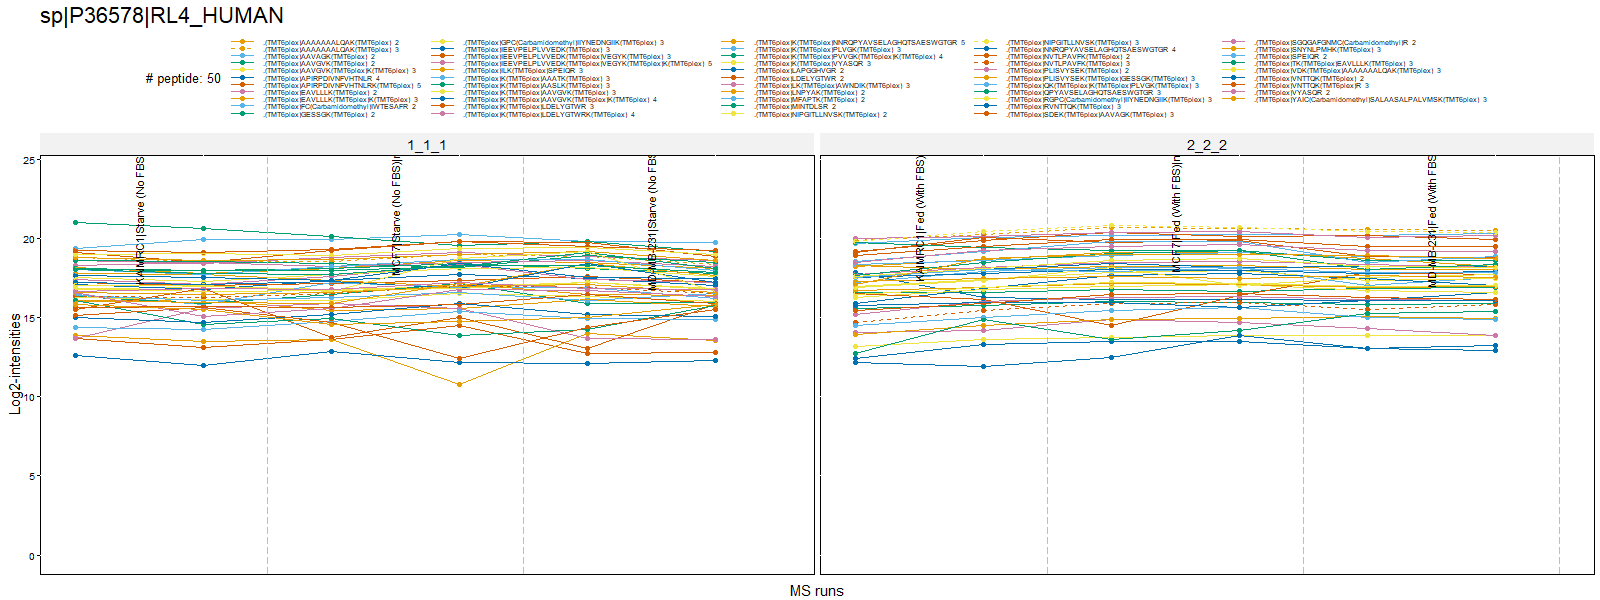

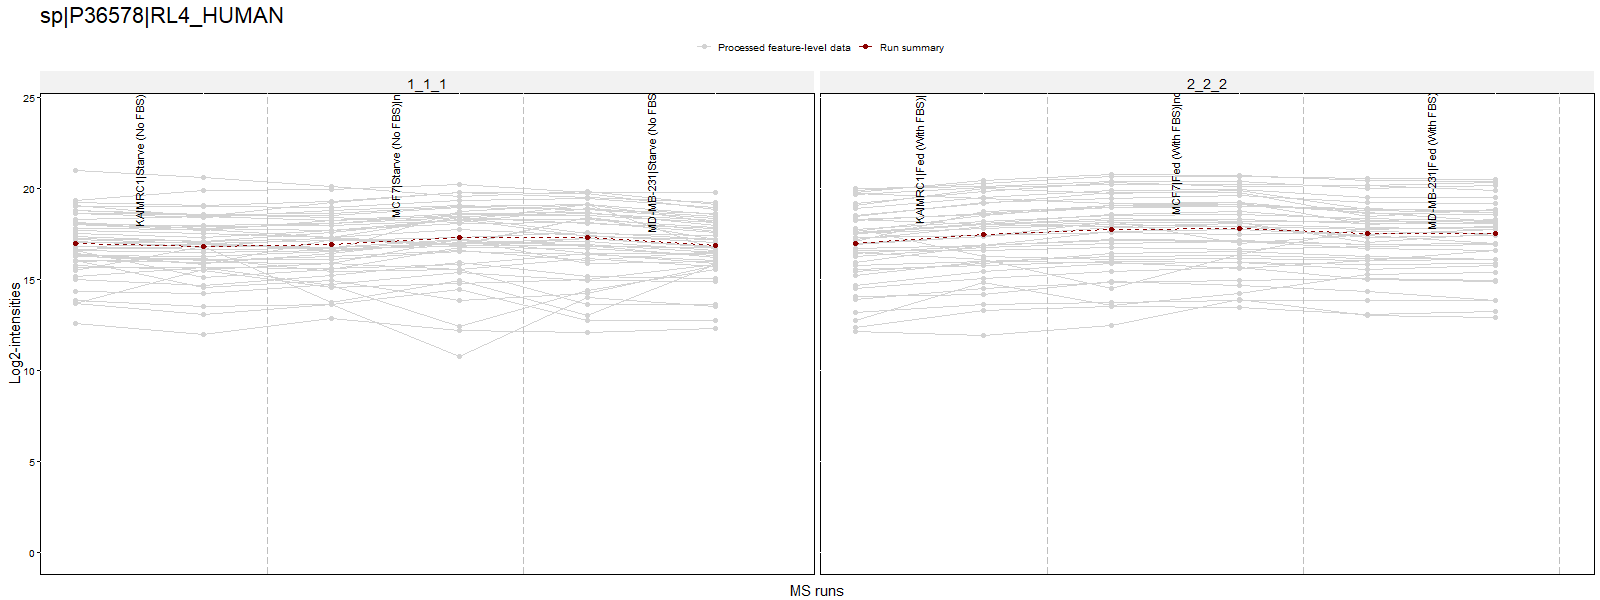

In [26]:
%%R -w 1600 -h 600

protein_expression = './protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = FALSE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P36578|RL4_HUMAN',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)
http://ftp.ebi.ac.uk/pride-archive/2012/03/PXD000001/TMT_Erwinia_1uLSike_Top10HCD_isol2_45stepped_60min_01.raw
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]
write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



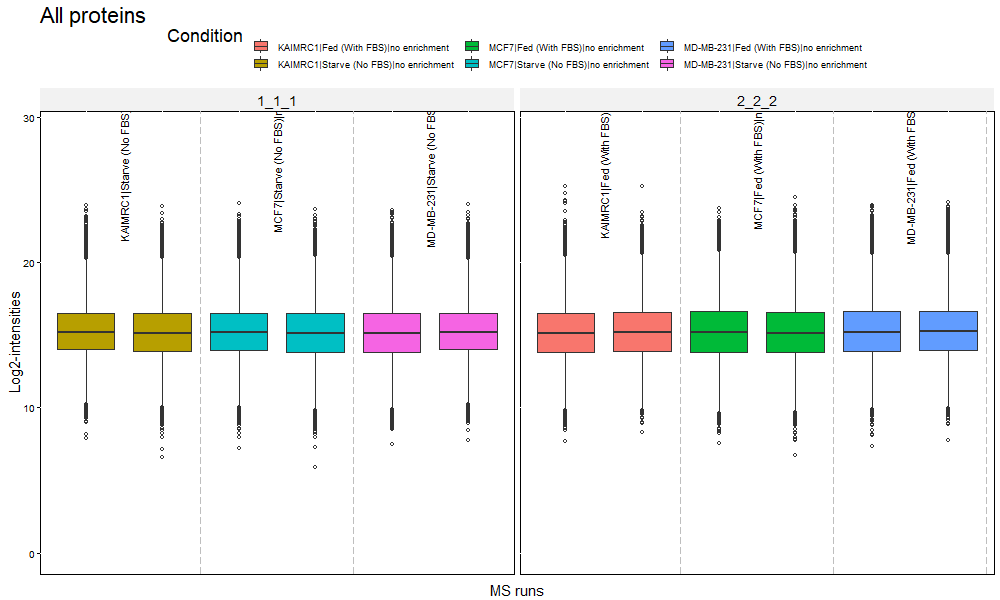

In [27]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)

## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [28]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "KAIMRC1|Fed (With FBS)|no enrichment"   
[2] "KAIMRC1|Starve (No FBS)|no enrichment"  
[3] "MCF7|Fed (With FBS)|no enrichment"      
[4] "MCF7|Starve (No FBS)|no enrichment"     
[5] "MD-MB-231|Fed (With FBS)|no enrichment" 
[6] "MD-MB-231|Starve (No FBS)|no enrichment"


In [30]:
%%R -w 1000 -h 600


Cell_Lines_Comp<-matrix(c(1, 1, 0, 0, 0, 0, 1, 1, -1, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, -1),nrow=4)
row.names(Cell_Lines_Comp)<-c("KAIMRC1|Fed vs MCF7|Fed", "KAIMRC1|Fed vs MDA-MB-231|Fed", "KAIMRC1|Starve vs MCF7|Starve", 
                             "KAIMRC1|Starve vs MDA-MB-231|Starve")
colnames(Cell_Lines_Comp) = c("KAIMRC1|Fed (With FBS)|no enrichment","KAIMRC1|Starve (No FBS)|no enrichment", 
                              "MCF7|Fed (With FBS)|no enrichment","MCF7|Starve (No FBS)|no enrichment",
                              "MD-MB-231|Fed (With FBS)|no enrichment", "MD-MB-231|Starve (No FBS)|no enrichment")


Cell_Lines_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Cell_Lines_Comp, moderated = TRUE)

INFO  [2021-10-27 20:35:15] Model fitting for 5347 proteins.
  |======================================================================| 100%
INFO  [2021-10-27 20:38:18] Testing for 5347 proteins:
  |======================================================================| 100%


In [39]:
%%R

head(Cell_Lines_Comp.pairwise$ComparisonResult)
ComparisonResult = Cell_Lines_Comp.pairwise$ComparisonResult
FedCondition = subset(ComparisonResult, grepl("Fed", Label))
write.table(FedCondition, "./FedDEP.csv", row.names=FALSE, col.names=TRUE, sep=',')

StarveCondition = subset(ComparisonResult, grepl("Starve", Label))
write.table(StarveCondition, "./StarveDEP.csv", row.names=FALSE, col.names=TRUE, sep=',')

#### Visualization normal condition

In [53]:
FedDEP = pd.read_csv('./FedDEP.csv', header=0, sep=',')
FedDEP = FedDEP[['Protein', 'Label', 'log2FC', 'pvalue']]
FedDEP.dropna(axis=0, inplace=True)
FedDEP["-Log10(p-value)"] = -np.log10(FedDEP['pvalue'])

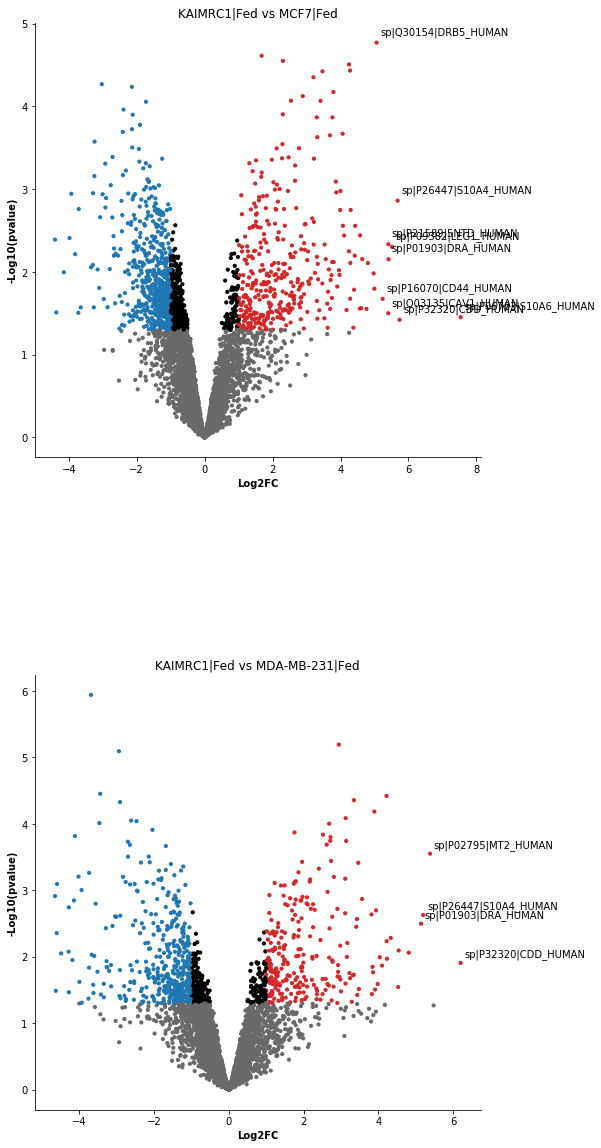

In [64]:
FedDEP['group'] = 'black'
FedDEP.loc[(FedDEP['log2FC'] > 1)&(FedDEP['pvalue'] < 0.05),'group'] = 'tab:red' 
FedDEP.loc[(FedDEP['log2FC'] < -1)&(FedDEP['pvalue'] < 0.05),'group'] = 'tab:blue'
FedDEP.loc[FedDEP['pvalue'] >= 0.05,'group'] = 'dimgrey'

fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(FedDEP['Label']):
    data = FedDEP[FedDEP['Label'] == comp]
    ax = fig.add_subplot(310 + i)
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    ax.set_title(comp)

    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 5)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
    i += 1
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


#### comparing with original result

In [66]:
from venn import venn


table_s3 = pd.read_excel('./Table_S3.xlsx', header=0)
fed_table_s3 = table_s3[table_s3['FBS'] == 'fed']

for label in np.unique(FedDEP['Label']):
    print(label)

venn.venn2()

KAIMRC1|Fed vs MCF7|Fed
KAIMRC1|Fed vs MDA-MB-231|Fed


AttributeError: 'functools.partial' object has no attribute 'venn2'

                                             Protein  \
0                            sp|A0A0G2K1Q8|ABCA3_RAT   
1                                 sp|A0JPJ7|OLA1_RAT   
2                                sp|A0JPM9|EIF3J_RAT   
3                                 sp|A7VJC2|ROA2_RAT   
4  sp|A9UMV8|H2AJ_RAT;sp|P02262|H2A1_RAT;sp|P0C16...   

                           Label    log2FC    pvalue  -Log10(p-value)  \
0  acute pancreatitis vs control -0.969125  0.002654         2.576085   
1  acute pancreatitis vs control  0.263631  0.081665         1.087965   
2  acute pancreatitis vs control  0.362955  0.540736         0.267015   
3  acute pancreatitis vs control -0.162050  0.388170         0.410978   
4  acute pancreatitis vs control -0.134704  0.568082         0.245589   

      group  
0  tab:blue  
1   dimgrey  
2   dimgrey  
3   dimgrey  
4   dimgrey  


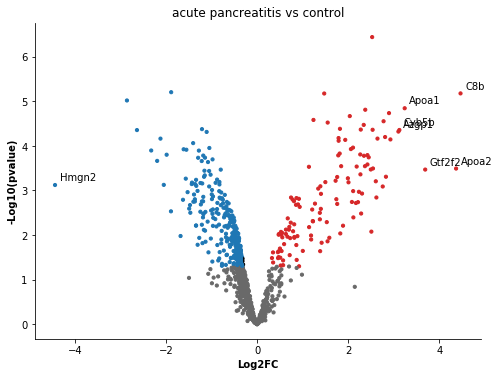

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
import math

def preprocess(s):
    return s.split('|')[-1]

result = pd.read_csv('./Soluble_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > math.log2(1.25))&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < math.log2(0.8))&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(410 + i)
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

#### Comparing differentially expressed proteins

##### Most of differentially expressed proteins given in the article are in out results, and we qutified more differentially expressed proteins

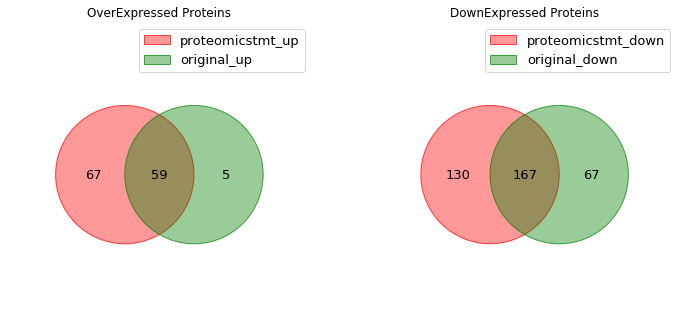

In [23]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from venn import venn

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
result = pd.read_csv('./Soluble_Comp_result.csv', sep=',')
original_soluble_result = pd.read_excel("./Soluble_fraction.xlsx", sheet_name="Quantifications")
original_soluble_up = original_soluble_result[(original_soluble_result["Is Significant"])&
                                              (original_soluble_result["Ratio"] > 1.0)]["ID"]
original_soluble_down = original_soluble_result[(original_soluble_result["Is Significant"])&
                                              (original_soluble_result["Ratio"] < 1.0)]["ID"]

t = result[result["Label"] == "acute pancreatitis vs control"]
t["ID"] = t.apply(lambda x: x.Protein.split('|')[-1], axis=1)
soluble_over_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] > 0)]["ID"]
soluble_under_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] < 0)]["ID"]

axs[0].set_title("OverExpressed Proteins")
venn({"proteomicstmt_up": set(soluble_over_expressed), "original_up": set(original_soluble_up)}, ax=axs[0], cmap=['r', 'g'])

axs[1].set_title("DownExpressed Proteins")
venn({"proteomicstmt_down": set(soluble_under_expressed), "original_down": set(original_soluble_down)}, ax=axs[1], cmap=['r', 'g'])

### Membrane fraction

#### Compared with the original picture, the overlapping part of the differential protein is too small. But we found more and more significant difference proteins

In [24]:
%%R -w 800 -h 600

openms_output = './out_msstats_membrane.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

raw.om$Condition[which(raw.om$Condition == "membrane fraction of pancreas|control")] <- "control"
raw.om$Condition[which(raw.om$Condition == "membrane fraction of pancreas|acute pancreatitis")] <- "acute pancreatitis"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)


INFO  [2021-10-21 14:17:08] ** Raw data from OpenMS imported successfully.
INFO  [2021-10-21 14:17:08] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-10-21 14:17:08] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-10-21 14:17:08] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-10-21 14:17:09] ** Shared peptides are removed.
INFO  [2021-10-21 14:17:09] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-10-21 14:17:15] ** PSMs have been aggregated to peptide ions.
INFO  [2021-10-21 14:17:16] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-10-21 14:17:16] ** Fractions belongin

INFO  [2021-10-21 14:24:51] ** MSstatsTMT - proteinSummarization function
INFO  [2021-10-21 14:24:51] Summarizing for Run : 2_2_2 ( 1  of  1 )
  |======================================================================| 100%
INFO  [2021-10-21 14:25:02] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


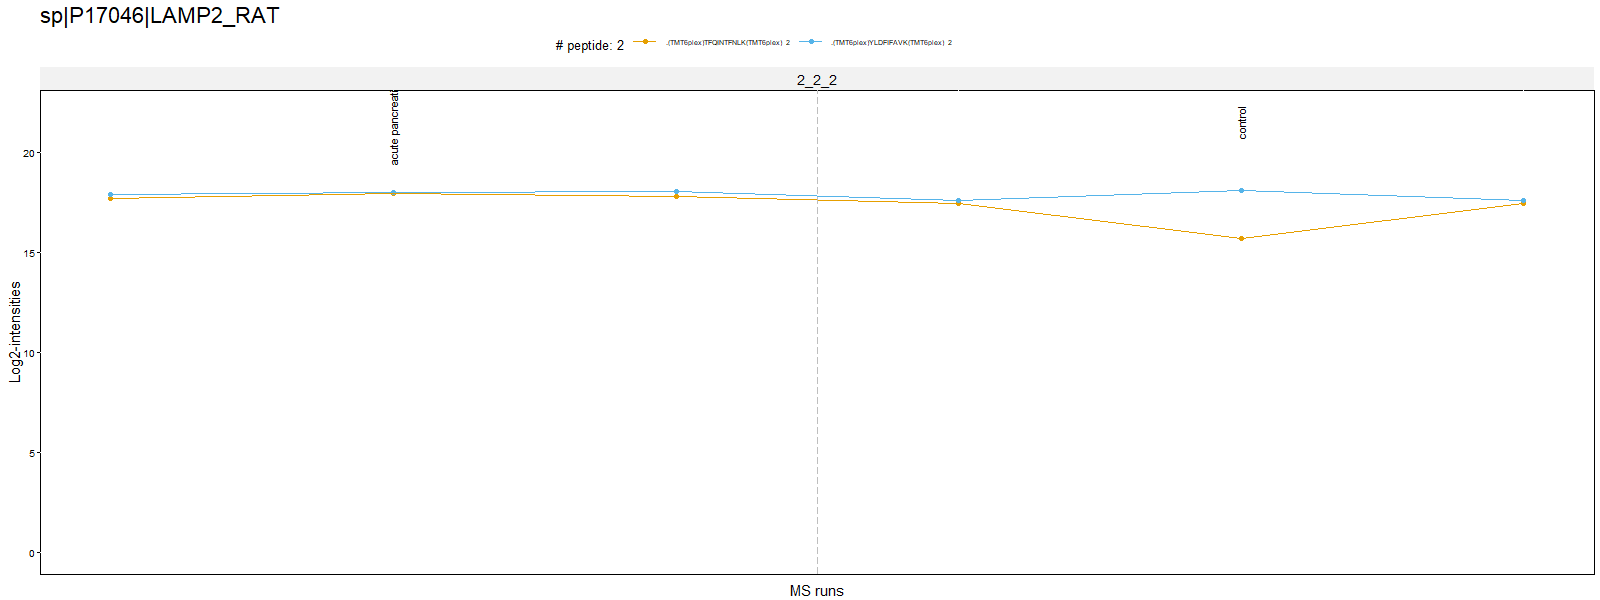

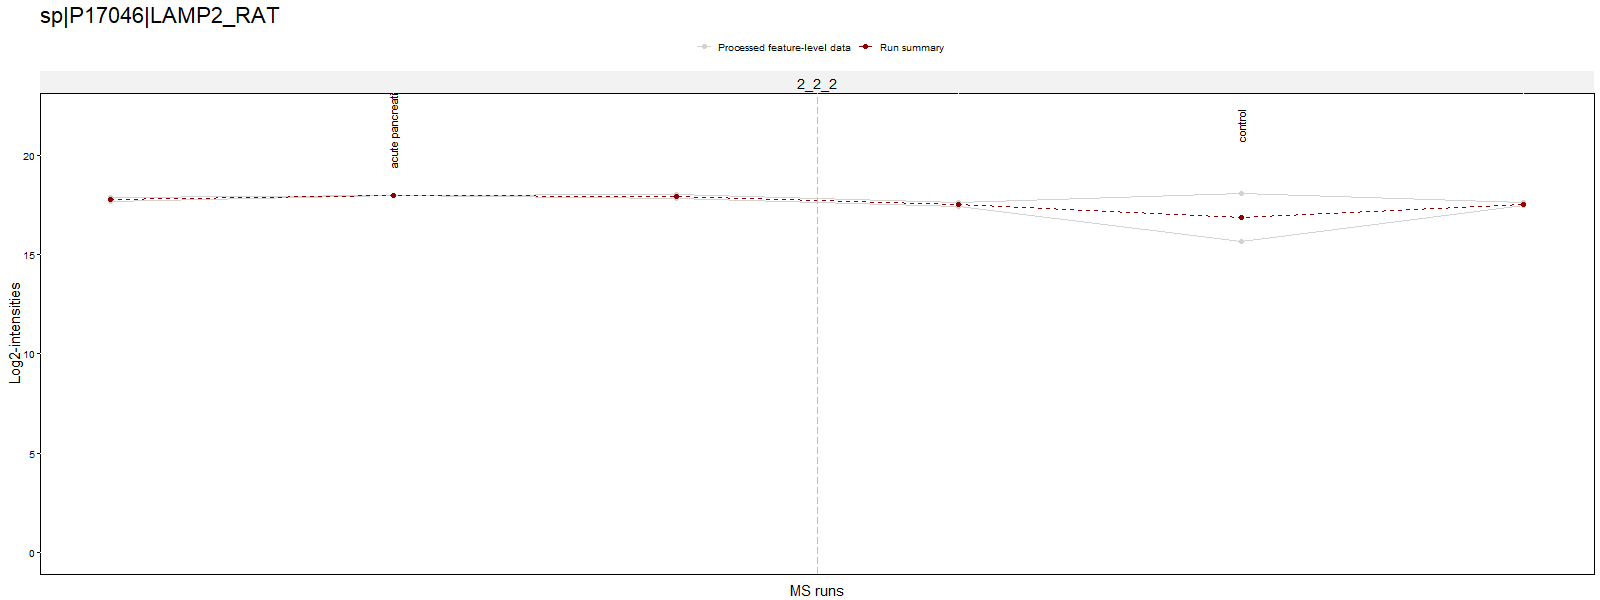

In [25]:
%%R -w 1600 -h 600

protein_expression = './membrane_protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P17046|LAMP2_RAT',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)



R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



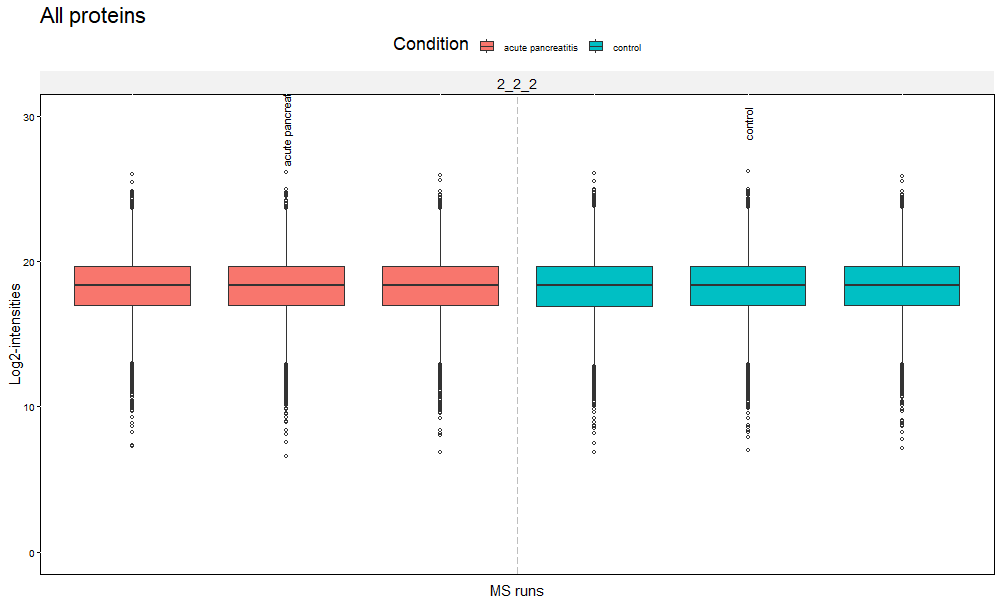

In [26]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)

## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)


In [27]:
%%R -w 1000 -h 600

levels(quant_om.msstats$ProteinLevelData$Condition)

Cancer_Normal_Comp<-matrix(c(1, -1),nrow=1)
row.names(Cancer_Normal_Comp)<-c("acute pancreatitis vs control")
colnames(Cancer_Normal_Comp) = c("acute pancreatitis","control")

Cancer_Normal_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Cancer_Normal_Comp, moderated = TRUE)
Cancer_Normal_Comp = Cancer_Normal_Comp.pairwise$ComparisonResult
write.table(Cancer_Normal_Comp,"Membrane_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")


INFO  [2021-10-21 14:29:17] Model fitting for 1070 proteins.
  |======================================================================| 100%
INFO  [2021-10-21 14:29:24] Testing for 1070 proteins:
  |======================================================================| 100%


                   Protein                          Label    log2FC    pvalue  \
0  sp|A0A0G2JUG7|IQEC1_RAT  acute pancreatitis vs control  0.205692  0.094560   
1  sp|A0A0G2K047|ACSS3_RAT  acute pancreatitis vs control  0.246938  0.154557   
2  sp|A0A0G2K1Q8|ABCA3_RAT  acute pancreatitis vs control -0.095749  0.861847   
3       sp|A0JPJ7|OLA1_RAT  acute pancreatitis vs control -1.270391  0.000032   
4      sp|A0JPL0|ZN382_RAT  acute pancreatitis vs control  0.115114  0.392775   

   -Log10(p-value)     group  
0         1.024291   dimgrey  
1         0.810911   dimgrey  
2         0.064570   dimgrey  
3         4.498634  tab:blue  
4         0.405856   dimgrey  


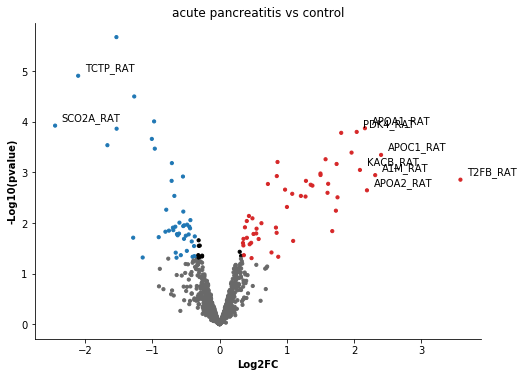

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
import math

def preprocess(s):
    return s.split('|')[-1]

result = pd.read_csv('./Membrane_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > math.log2(1.25))&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < math.log2(0.8))&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(410 + i)
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    ax.set_title(comp)
    i += 1
    
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 2)].iterrows():
        ax.annotate(preprocess(row['Protein']), xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

#### comparing differentially expressed proteins

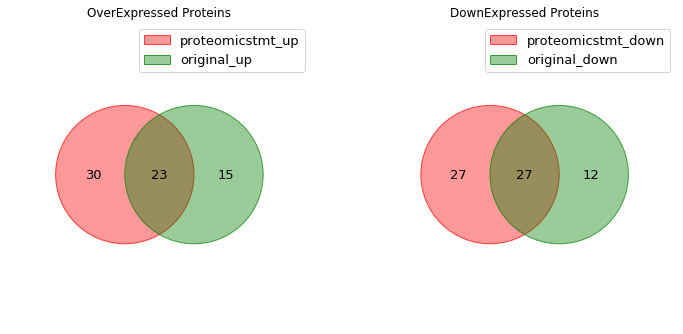

In [31]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from venn import venn

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
result = pd.read_csv('./Membrane_Comp_result.csv', sep=',')
original_membrane_result = pd.read_excel("./Membrane_fraction.xlsx", sheet_name="Quantifications")
original_membrane_up = original_membrane_result[(original_membrane_result["Is Significant"])&
                                              (original_membrane_result["Ratio"] > 1.0)]["ID"]
original_membrane_down = original_membrane_result[(original_membrane_result["Is Significant"])&
                                              (original_membrane_result["Ratio"] < 1.0)]["ID"]

t = result[result["Label"] == "acute pancreatitis vs control"]
t["ID"] = t.apply(lambda x: x.Protein.split('|')[-1], axis=1)
soluble_over_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] > 0)]["ID"]
soluble_under_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] < 0)]["ID"]

axs[0].set_title("OverExpressed Proteins")
venn({"proteomicstmt_up": set(soluble_over_expressed), "original_up": set(original_membrane_up)}, ax=axs[0], cmap=['r', 'g'])

axs[1].set_title("DownExpressed Proteins")
venn({"proteomicstmt_down": set(soluble_under_expressed), "original_down": set(original_membrane_down)}, ax=axs[1], cmap=['r', 'g'])